<a href="https://colab.research.google.com/github/lejimmy/handson-ml-workbooks/blob/master/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST

In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “Hello World” of Machine Learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST. Whenever someone learns Machine Learning, sooner or later they tackle MNIST.

In [0]:
import time
import pickle
from joblib import dump, load

In [0]:
from sklearn.datasets import fetch_openml

# fetches the MNIST dataset
mnist = fetch_openml('mnist_784', version = 1)

# view dictionary of keys
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:
- A `DESCR` key describing the dataset
- A `data` key containing an array with one row per instances and one column per feature
- A `target` key containing an array with the labels

Note: these are read in as a dictionary and not as a pandas DataFrame.

In [0]:
# call dictionary for 'data' and 'target'
X, y = mnist['data'], mnist['target']

# print dictionary shapes
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


There are 70,000 rows of images and each image has 784 features.

Each image is 28x28 (784 pixels) and each feature represents each pixel's intensity from 0 (white) to 255 (black).

We will grab one digit by grabbing the feature vector and reshaping it into a 28x28 array.  Then we will display it with Matplotlib's `imshow()` function.

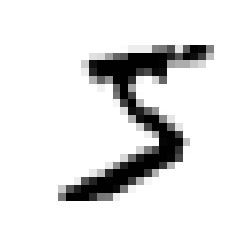

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# get the first instance
some_digit = X[0]

# turn the since row of 784 numbers into 28 rows of 28 numbers
some_digit_image = some_digit.reshape(28, 28)

# plot the image in black and white
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

plot_digit(some_digit_image)
plt.show()

In [0]:
# view label
y[0]

'5'

The image is clearly a 5 and the label also indicates that it is a 5.

We can also see that the labels are a string.  Let's cast `y` to integers:

In [0]:
import numpy as np

# change y to integers
y = y.astype(np.uint8)

Before we proceed, remember to split the data into a training and test set!  The MNIST dataset is actually already split and shuffled such that all cross-validation folds will be similar.  Also, recall that some algoithms are sensitive to the order of training.

In [0]:
# split the first 60,000 into the training set and the last 10,000 into the testing set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

Let's simplify the problem for now and try to identify one digit - for example the number 5.  This binary classifier will be able to distinguish between 5 and not-5.

In [0]:
# True for all 5's and False for all other digits
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Previously for regression, we chose a regression algorithm and trained it.  Here we will choose a classifier and train it.

In this first example we will start with a *Stochastic Gradient Descent (SGD)* classifier using Scikit-Learn's `SGDClassifier` class.  Stochastic refers to being randomly determined.

The SGD classifier is able to handle large datasets efficiently because it trains instances independently (one at a time).  This also means that SGD is well suited for *online learning*.  More on that later.

In [0]:
from sklearn.linear_model import SGDClassifier

# construct the SGDClassifier, set random_state for reproducibility
sgd_clf = SGDClassifier(random_state = 42)
start_time = time.time()
sgd_clf.fit(X_train, y_train_5)
print('Training took {:.2f} seconds'.format(time.time() - start_time))

Training took 27.79 seconds


Now that our model is trained, let's test it on our digit from earlier.

In [0]:
# predict our first entry
sgd_clf.predict([some_digit])

array([ True])

It looks like it guessed the 5 to be true in this case!  Let's evaluate the model's performance.

# Performance Measures

Classifier performance is trickier than a regressor, so let's dive in!

## Measuring Accuracy Using Cross-Validation

We will use `cross_val_score()` to evaluate the SGDClassifier model, using K-fold cross-validation with three folds.

In [0]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

At first glance this looks amazing!  Every fold scored over 90% on all cross-validation folds.

However, before we get too excited, let's look at a very dumb classifier that classifies every single image in the 'not-5' class:

In [0]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y = None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype = bool)
  
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

Again, we have over 90% accuracy!  This is simply because only 10% of the images are 5s, so if you always guess that the image is not a 5, you will be right 90% of the time.

## Confusion Matrix

A better way to evaluate the performance of a classifier is to look at the *confusion matrix*.  The general idea is to count the number of times instances of Class A are classified as class B.  For example, how many times did the classifier confuse the images of 5s with 3s?

To compute this confusion matrix, we will first need a set of predictions so they can be compared to the actual targets.  To keep our test set untouched until the very end of the project, we will instead use the `cross_val_predict()` function:

In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

Similar to the `cross_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.  This means you get a clean (model never saw the data during training) prediction for each instance in the training set.

Now let's get the `confusion_matrix()`.

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row represents an *actual* class (5s and non-5s), and each column represents a *predicted* class.

The first row is the *negative class*.  53,892 were not 5 and correctly predicted as non-5s (true negatives).  687 were 5 but incorrectly predicted as non-5s (false positives).

The second row is the *positive class*.  1,891 were wrongly classified as non-5s (false negatives), while 3,530 were correctly classified as 5s (true positives).

A perfect classifer would only have true positives and true negatives as simulated below:

In [0]:
# pretend we predicted perfect 5s
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

To get a more concise metric, we can look at the *precision* of the classifier:

$precision = \frac{TP}{TP+FP}$

TP = number of true positives
FP = number of false positives

Precision is commonly used with another metric named *recall* aka *sensitivity* or *true positive rate* (TPR)

$recall = \frac{TP}{TP + FN}$

FN = number of false negatives

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0302.png)

## Precision and Recall

Scikit-Learn provides several functions to help compute classifier metrics:

In [0]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [0]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

When our classifier claims that an image represents a 5, it is correct 83% of the time.  It is only detecting 65% of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1score to simply compare two classifiers.

The F1score is the *harmonic mean* of precision and recall.

A harmoic mean gives much more weight to low values.  As a result, to get a high F1 score, both recall and precision must be high.

$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2 * \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN+FP}{2}}$

In [0]:
from sklearn.metrics import f1_score

# compute f1 score based on the labels vs the predictions
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers with similar precision and recall.  However, depending on your application you may only care about precision and in some other contexts you may really only care about recall.

*e.g. a classifer to detect if videos are safe for kids, you want a classifer that rejects many good videos (low recall) in favor of keeping only safe ones (high precision).*

*e.g. a classifer to detect shoplifters on surveillance images: 30% precision as long as it has 99% recall.  Their will be some false alerts but almost all shoplifters will get caught.*

However, there is a tradeoff.  The *precision/recall trade-off* tells us that typically increasing precision reduces recall, and vice versa.

## Precision/Recall Trade-off

The `SGDClassifer` makes its classification decision by computer a score based on a *decision function*.  If the score is greater than a threshhold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

As you raise the threshold, the precision increases whiel the recall decreases.

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0303.png)

Though Scikit-Learn doesn't let you set the threshold directly, you can access the decision scores it uses to make predictions.

In [0]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [0]:
# default threshold for SGDClassifer is 0
threshold = 0
y_some_digit_pred = y_scores > threshold
print(y_some_digit_pred)

# artificially raising the threshold
threshold = 8000
y_some_digit_pred = y_scores > threshold
print(y_some_digit_pred)

[ True]
[False]


If we raise the threshold to be 8,000 then the classifier misses the prediction, reducing it's recall.

To determine the possible thresholds, we will use `cross_val_predict()` to get all of the scores.  Instead of returning the prediction, we will ask for a return of the decision scores.

In [0]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                             method = 'decision_function')

We can use the `precision_recall_curve()` to compute precision and recall for all possible thresholds.

In [0]:
from sklearn.metrics import precision_recall_curve

# for every threshold, return the precision and recall lines
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

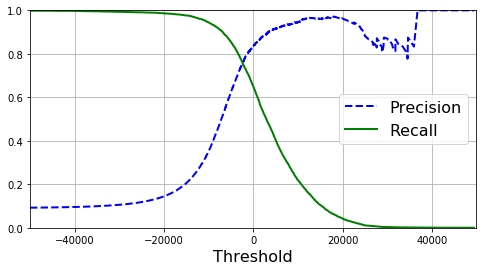

In [0]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  # plot lines
  plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision', linewidth = 2)
  plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall', linewidth = 2)
  
  # plot properties
  plt.legend(loc="center right", fontsize=16) 
  plt.xlabel("Threshold", fontsize=16)        
  plt.grid(True)                              
  plt.axis([-50000, 50000, 0, 1])            

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

We can also plot precision directly against recall to select a good precision/recall trade-off.

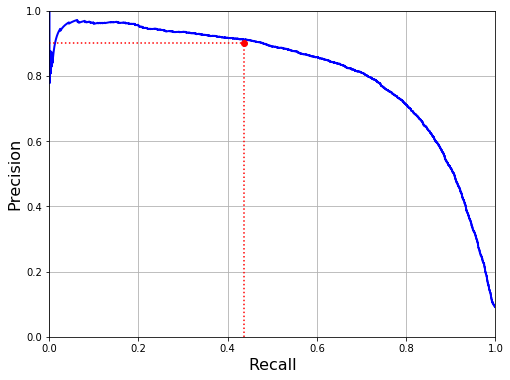

In [0]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

We notice that precision starts to fall sharply around 80% recall.  If you decide to aim for a 90% precision, you can see that the threshold will be around 8,000.

To be more precise we can search for the lowest threshold that will give us at least 90% precision.

In [0]:
# return an array of precisions >= .90
# give me the largest index
# find the corresponding threshold at that index
threshold_90_precision = thresholds[np.argmax(precisions >= .90)]

To make predictions on the training set, we can run this line:

In [0]:
# return true or false based on the scores and our custom threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)

# check precision
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [0]:
# check recall
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Great!  Now we have a 90% precision classifier!  However, as you can see it may not be very useful if the recall is too low.

## The ROC Curve

The *receiving operating characterisctic* (ROC) is another common tool used with binary classifiers.  The ROC curve plots the *true positive rate* (recall) against the *false positive rate*.   The FPR is the ratio of negative instances that are incorrectly classified as positive.  It is equal to 1 - the *true negative rate*.

The TNR is the ratio of negative instances that are correctly classified as negative.  The TNR is also called *specificity*.  The ROC curve plots *sensitivity* (recall) versus 1 - *specificity*.

To plot the ROC curve, we can use the `roc_curve()` function to compute the TPR and FPR for various thresholds.  Then we can plot them in Matplotlib.

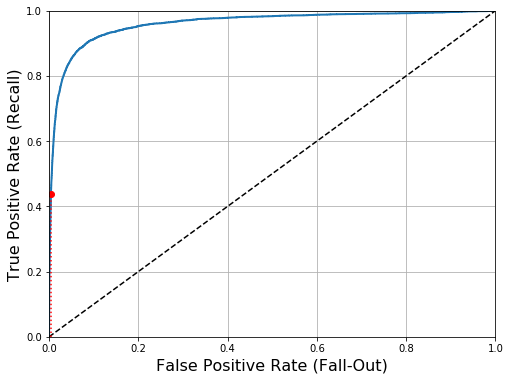

In [0]:
from sklearn.metrics import roc_curve

# compute TPR, FPR and various thresholds
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = 'None'):
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])                                    # Not shown in the book
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
  plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
  plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
  
plt.show()

Again, we can see the trade-off between higher recall (TPR) and more false positives (FPR).  The dotted line represents the ROC curve of a purely random classifier, a good classifer moves towards the top-left corner.

Another way to compare classifers is to measure the *area under the curve* (AUC).  A perfect classifer will have a ROC AUC equal to one.  A purely random classifier will have a ROC AUC equal to 0.5.

In [0]:
from sklearn.metrics import roc_auc_score

# auc score based on our training set and our scores
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

TIP: Whenever the positive class is rare when you care more about the false positives than the false negatives, you should use a PR curve - otherwise use the ROC curve.

Let's train a `RandomForestClassifer` and compare the ROC curve and ROC AUC score to the `SGDClassifer`.

Since the `RandomForestClassifer` doesn't have a `decision_function()` method, we will have to use its `predict_proba()` method instead.

The `predict_proba()` method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class.

In [0]:
from sklearn.ensemble import RandomForestClassifier

# random forest classifier constructor
forest_clf = RandomForestClassifier(random_state = 42)

# return array of probabilities of each class
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                    method = 'predict_proba')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Since ROC curves need scores, while the `predict_probab()` method returns an array of probabilities, we can use the first column of probabilities as our score.

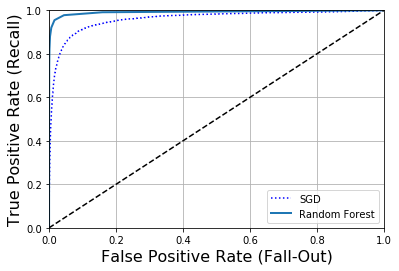

In [0]:
# use first column of probabilities as scores
y_scores_forest = y_probas_forest[:, 1]

# false positive rate, true positive rate, and threshold numbers
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# plot SGD and Random Forest ROC curves
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc = 'lower right')
plt.show()

The `RandomForestClassifier`'s ROC curve looks much better than the `SGDClassifer`'s.  Closer to the top left corner is better!

Let's also check the ROC AUC score:

In [0]:
# roc score
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

In [0]:
# predict the labels based on our classifier
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)

# precision score
precision_score(y_train_5, y_train_pred_forest)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.986046511627907

In [0]:
# recall score
recall_score(y_train_5, y_train_pred_forest)

0.8212506917542889

So far we have learned how to:
- Train binary classifiers
- Choose the appropriate metric for our task
- Evaluate classifiers using cross-validation
- Select the precision/recall trade-off that fits our needs
- Use ROC curves and ROC AUC scores to compare models

Now, let's try to detect more than just 5s.

# Multiclass Classification

Binary Classifiers:
- Logistic Regression
- Support Vector Machine

Multiclass Classifiers (multinomial classifiers):
- Stochastic Gradient Decent (SGD)
- Random Forest
- Naive Bayes

There are various strategies to perform multiclass classification with multiple binary classifiers.

*One-versus-all (one-versus-the-rest)*: We can train 10 binary classifiers, one for each digit and select the class where the classifier outputs the highest score.

*One-versus-one*: You train a binary classifier for every pair of digit.  0s and 1s, 0s and 2s, 1s and 2s, etc.  For *N* classes, you will train *N x (N - 1) / 2* classifiers.  So for the MNIST problem, we will need to train 45 classifiers!

Most binary classification algorithms prefer OvA.  However, for Support Vector Machine classifiers and other algorithms that scale poorly with the size of the training set, OvO is preferred as it is trained only on the smaller training subsets.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA or OvR, depending on the algorithm.

Let's try this with a support vector machine classifier:

In [0]:
from sklearn.svm import SVC

# support vector machine classifier constructor
svm_clf = SVC(gamma = 'auto', verbose = 3, random_state = 42)

# fit model to our training data
start_time = time.time()
print('Training begin at {:.2f}.'.format(start_time))
svm_clf.fit(X_train[:1000], y_train[:1000])
print('Training took {:.2f} seconds'.format(time.time() - start_time))

# predict our first row
svm_clf.predict([some_digit])

Training begin at 1565119240.12.
[LibSVM]Training took 1.94 seconds


array([5], dtype=uint8)

The above code trains the `SVC` on the training set using the original target classes from 0-9.  Then it makes a prediction.  Under the hood, Scikit-Learn is using the OvO strategy: it trained 45 binary classifiers, got their decision scores for each image, and selected the class that won the most duels.

Let's call the `decision_function()` method to see the 10 scores per instance:

In [0]:
# view decision function
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

Here we can see that the highest score is in the 6th position corresponding to the class 5.

In [0]:
np.argmax(some_digit_scores)

5

In [0]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### Saving and Loading Models in Google Drive

In [0]:
# save model to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

working_directory = '/content/drive/My Drive/Colab Notebooks/'
filename = 'mnist_svm.sav'

pickle.dump(svm_clf, open(working_directory + filename, 'wb'))

Mounted at /content/drive


In [0]:
# load previous saved model
infile = open(working_directory + filename, 'rb')
f = pickle.load(infile)

To force Scikit-Learn to use one-versus-one or one-versus-all, we can use the `OneVsOneClassifier` or `OneVsRestClassifer` classes.

In [0]:
from sklearn.multiclass import OneVsRestClassifier

# passing SVC through One Vs Rest Classifier
ovr_clf = OneVsRestClassifier(SVC(gamma = 'auto', random_state = 42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

Training an `SGDClassifier` or `RandomForestClassifier` is just as easy:

In [0]:
# train SGDClassifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

SGD classifiers directly classify instances into multiple classes.  The `decision_function()` returns one value per class.  Let's take a look here:

In [0]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [0]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87082583, 0.87089354, 0.88628294])

To increase our score, we can use a Standard Scaler as discussed in Chapter 2.

In [0]:
from sklearn.preprocessing import StandardScaler

# standard scaler constructor
scaler = StandardScaler()

# standardize the inputs
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# accuracy score across 3 test folds
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

In [0]:
filename = 'mnist_sgd.sav'
pickle.dump(sgd_clf, open(working_directory + filename, 'wb'))

# Error Analysis

In a typical project, we would follow the checklist as follows: 
- Explore data preparation options
- Try multiple models
- Shortlist the best models
- Fine-tune the hyperparameters using `GridSearchCV`
- And automate as much as possible

From here, we will assume we have a promising model and are wanting to find ways to improve it.  One wasy is to analyze the type of errors it makes.

We'll first look at the confusion matrix.

In [0]:
# make predictions
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)

# view confusion matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

Instead of just looking at the numbers, we will simplify the representation, by using Matplotlib's `matshow()` function.

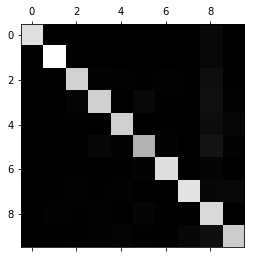

In [0]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

Since most of the images appear on the main diagonal, this means the model is correctly classifying the numbers.

Since the 5s look a bit darker than the other digits, this could mean there are fewer 5s in the dataset or that the classifier does not perform well on 5s.

Let's plot the errors.  We will divide each value in the confusion matrix by th e number of images in the corresponding class to compare error rates instead of absolute number of errors.

In [0]:
# sum of all rows in confusion matrix
row_sums = conf_mx.sum(axis = 1, keepdims = True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [0]:
# normalize confusion matrix
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.41414824e-01, 0.00000000e+00, 3.54550059e-03, 1.01300017e-03,
        1.51950025e-03, 7.25983454e-03, 6.24683437e-03, 1.01300017e-03,
        3.78186730e-02, 1.68833361e-04],
       [0.00000000e+00, 9.48976565e-01, 5.63630970e-03, 3.41145061e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.18659152e-03,
        3.15929991e-02, 1.48323939e-03],
       [4.36388050e-03, 4.53172205e-03, 8.79825445e-01, 1.51057402e-02,
        1.19167506e-02, 4.36388050e-03, 1.04061766e-02, 6.04229607e-03,
        6.22692179e-02, 1.17489090e-03],
       [3.91453270e-03, 2.77279400e-03, 1.90833469e-02, 8.51410863e-01,
        3.26211059e-04, 3.39259501e-02, 4.56695482e-03, 6.52422117e-03,
        6.60577394e-02, 1.14173870e-02],
       [2.05409106e-03, 2.39643958e-03, 8.21636426e-03, 1.71174255e-03,
        8.88736734e-01, 1.71174255e-03, 6.16227319e-03, 4.45053064e-03,
        5.64875043e-02, 2.80725779e-02],
       [5.16509869e-03, 2.76701716e-03, 6.08743774e-03, 3.06216565e-02,
   

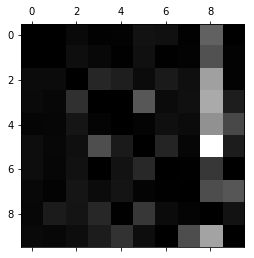

In [0]:
# fill diagonal to only show errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

Remember that rows are actual classes while columns are predicted classes.

Actual 8s are correctly being classified as 8s, however other numbers are being misclassified as 8s.

Analyzing the confusion matrix gives you insights on how to improve your classifier.  From this plot, we can see more effort should be spent on reducing the false 8s.

We could do this by gathering more training data for digits that look like 8s (but are not) or we could engineer new features to help the classifier.  Or we could engineer other features to help certain patterns stand out more.

Plotting individual errors can be a good way to gain ingihts on what the classifer is doing and why it is failing.

Let's plot examples of the 3s and 5s:

In [0]:
# provided function to plot digits
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

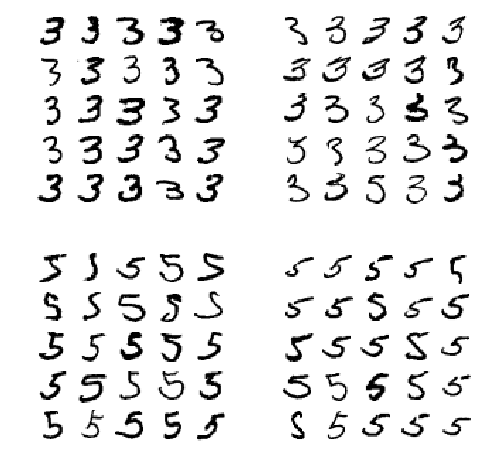

In [0]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

The top left 3s are actual 3s classified as 3s, while the bottom left are actual 5s classified as 5s.

The other sections are misclassified 3s and 5s.

It looks like the classifier is sensitive to image shifting and rotation.  To reduce the 3/5 confusion, we could preprocess the images to ensure they are well centered and not too rotated.

# Multilabel Classification

Sometimes you may want your classifier to output multiple classes for each instance.

Let's look at a simple example:

In [0]:
from sklearn.neighbors import KNeighborsClassifier

# create a multilabel of numbers that are 7 or greater or odd
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

# fit the training data on the multilabel
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
knn_clf.predict([some_digit])

array([[False,  True]])

It gets it right!  The number 5 is not large but it is odd.

Let's measure the F1 score for each individual label then compute the average score.

In [0]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train_scaled, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

0.9613989329409902

This code assumes that all labels are equally important, which may not be the case.

Suppose this was an image classifier and for the same picture Alice and Bob both appeared in the picture.

However, if it was Alice's Google Photos account, she would care more about photos she is labeled in.

One option to give more weight to a classifier's score is to label a weight equal to it's *support* (the number of instances with that target label).

To do this, all we would have to do is to change `average = 'weighted`.

In [0]:
filename = 'mnist_knn.sav'
pickle.dump(knn_clf, open(working_directory + filename, 'wb'))

# Multioutput Classification

*Multioutput-multiclass classification* or *multioutput classification* generalizes multilabel classification where each label can be a multiclass.  (i.e. it can have more than two possible values.)

To illustrate this, we will build a system that removes noise from images.

We will begin by creating a training and testing set by taking the MNIST images and adding noise to their pixel intensities with NumPy's `randint()` function.  The target images will be the original images:

In [0]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

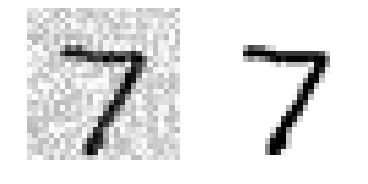

In [0]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

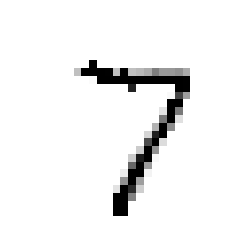

In [0]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)